# Patient type prediction step-by-step walkthrough

First, we do an EDA(Exploratory data analysis) of the patient dataset using pandas library

In [3]:
import pandas as pd

In [78]:
patient_two = pd.read_csv(r'data\train\two_classes.csv')

Eyeball the dataset to draw high level inferences on the dataset

In [5]:
patient_two

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,Normal
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,Normal
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,Normal
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,Normal


#### High level EDA
1. Dataset contains 310 rows and 7 columns, there are 6 features and one taregt class.
2. Six features seems to be observations of Orthopedic diagnostics of patients.
3. All features are numerical thus feature encoding is not required

Analyze the distribution of target column

In [6]:
patient_two['class'].value_counts()

Abnormal    210
Normal      100
Name: class, dtype: int64

Two classes of target variable i.e. Patient Type is observed and both have a fair share. Classes are not under-represented.

Analyze feature type

In [24]:
patient_two.dtypes

pelvic_incidence            float64
pelvic_tilt numeric         float64
lumbar_lordosis_angle       float64
sacral_slope                float64
pelvic_radius               float64
degree_spondylolisthesis    float64
class                        object
dtype: object

Features are all numeric. 

Analyeze feature distribution

In [208]:
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

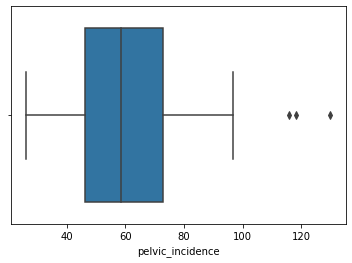

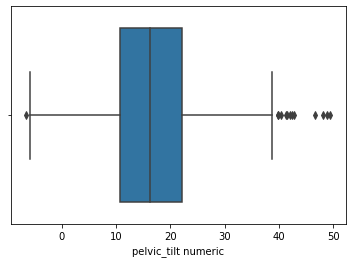

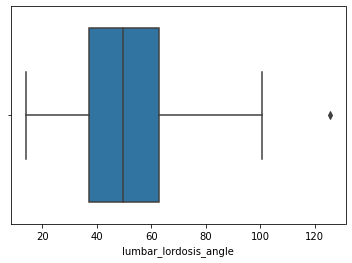

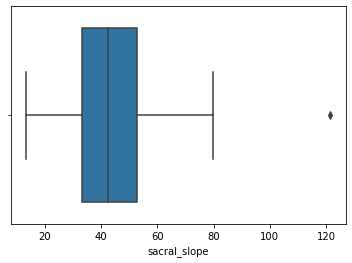

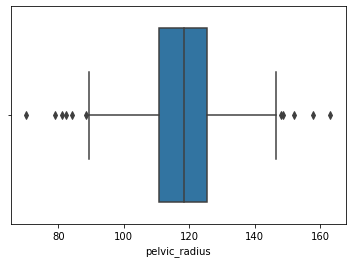

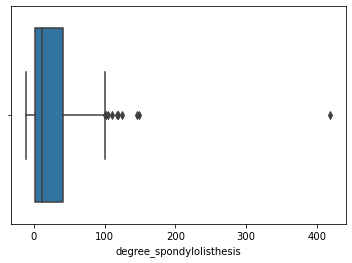

In [209]:
for features in patient_two.columns:
    if patient_two[features].dtypes != 'object':
        plt.figure()
        sb.boxplot(patient_two[features])
        plt.show()

All features have high outliers. Also, pelvic_tilt numeric and pelvic_radius has both lower and higher outliers.
Outliers can impact patient type classification, thus needs to be treated. 

First, model is built without dropping outliers to set a vanilla benchmark.

Since each feature is in varying scale they are scaled before feeding to the model.

#### Split dataset into train and test before applying Scaling to avoid data leak. 

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [174]:
#Seggregate the dataset into features and target column. Encode the target labels into numeric using LabelEncoders
features = patient_two.drop('class', axis=1)
target=patient_two['class']

le = LabelEncoder()
le.fit(target)
target = le.transform(target)
x_train,x_test,y_train,y_test=train_test_split(features,target, test_size=0.25)

In [175]:
from sklearn.preprocessing import MinMaxScaler

In [176]:
# Instantiate MinMaxScaler and fit the Train dataset. The fitted scaler shall be used for transforming training features 
# and test features

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)

In [177]:
#Import KNN Classifer 
from sklearn.neighbors import KNeighborsClassifier

In [178]:
#Initiate KNN model with arbitrary number of neighbours
knn_model = KNeighborsClassifier(n_neighbors=5)

In [179]:
knn_model.fit(x_train,y_train)

KNeighborsClassifier()

In [180]:
#Scale the test features
x_train = scaler.transform(x_train)

In [181]:
y_pred = knn_model.predict(x_test)

In [184]:
# Import model evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

In [185]:
# funciton to compure and return metrics. Also an optional parameter to print metircs. Metrics are returned for 
# further evaluation
def compute_model_metrics(y_test,y_pred, if_print):
    accuracy = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    auc = roc_auc_score(y_test,y_pred)
    if if_print == True:
        print('accuracy: {}'.format(accuracy))
        print('F1 Score: {}'.format(f1))
        print('Area under ROC Curve: {}'.format(auc))
    return accuracy, f1, auc

In [186]:
accuracy_1,f1_1, auc_1 = compute_model_metrics(y_test,y_pred,True)

accuracy: 0.6923076923076923
F1 Score: 0.0
Area under ROC Curve: 0.5


In [187]:
# The Accuracy is above 50% but F1 score is zero meaning model is a bad classifier.

In [188]:
#Check confusion matrix to check model bias.
confusion_matrix(y_test,y_pred)

array([[54,  0],
       [24,  0]], dtype=int64)

It is inferred from Confusion matix that the model classifies all patients as '0' i.e. 'abnormal'. Thus, the model is overfit to class label '0' i.e. 'Abnormal' patient. Hyperparameter tuning is requred to achieve better results

In [190]:
# Iterate over hyperparameter to identify optimum values
auc_dict = {}

for n_neighbors in range(3,50):
    knn_model = KNeighborsClassifier(n_neighbors)
    knn_model.fit(x_train,y_train)
    y_pred = knn_model.predict(x_test)
    auc_dict[n_neighbors] = roc_auc_score(y_test,y_pred)

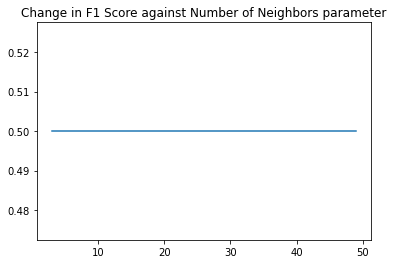

In [226]:
plt.figure()
plt.plot(*zip(*sorted(auc_dict.items())))
plt.title("Change in F1 Score against Number of Neighbors parameter")
plt.show()

#### Change in Hyperparameter does not improve F1 score. This implies model is indifferent to hyper parameter tuning. Thus, data pre processing strategy needs to change.

In [ ]:
# 
from sklearn.preprocessing import 
x_train,x_test,y_train,y_test=train_test_split(features,target, test_size=0.25)